<a href="https://colab.research.google.com/github/Varun-3000/Sentiment-Analysis-Using-Reddit-API/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install praw textblob pyspark

In [44]:
import praw
import pandas as pd
from textblob import TextBlob
from datetime import datetime
import os
import config
from pyspark.sql import SparkSession
# Make sure the directory exists
os.makedirs("/dbfs/FileStore/reddit", exist_ok=True)


In [45]:
# Reddit API Auth
reddit = praw.Reddit(
    client_id=config.client_id,
    client_secret=config.client_secret,
    user_agent=config.user_agent,
)

In [46]:
# Fetch latest comments
comments = reddit.subreddit("Python").comments(limit=10)

In [47]:
# Analyze
data = []
for comment in comments:
    polarity = TextBlob(comment.body).sentiment.polarity
    sentiment = "positive" if polarity > 0 else "negative" if polarity < 0 else "neutral"
    data.append({
        "timestamp": datetime.utcfromtimestamp(comment.created_utc),
        "author": comment.author.name if comment.author else "N/A",
        "comment": comment.body,
        "sentiment": sentiment
    })


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [48]:
spark = SparkSession.builder \
    .appName("RedditSentiment") \
    .getOrCreate()
# Convert to Spark DF
df = spark.createDataFrame(pd.DataFrame(data))

# Save as Parquet (for efficient storage)
df.write.mode("overwrite").parquet("/dbfs/FileStore/reddit/reddit_sentiment.parquet")

# Convert to CSV for GitHub
df.toPandas().to_csv("/dbfs/FileStore/reddit/reddit_sentiment.csv", index=False)

In [49]:
df_pd = pd.read_csv("/dbfs/FileStore/reddit/reddit_sentiment.csv")
print(df_pd.head())


             timestamp                author  \
0  2025-05-06 16:54:14         BostonBaggins   
1  2025-05-06 16:46:06    case_O_The_Mondays   
2  2025-05-06 16:45:50              yerfatma   
3  2025-05-06 16:41:52  Angry-Toothpaste-610   
4  2025-05-06 16:41:39               Amgadoz   

                                             comment sentiment  
0                    Dam that is a toxic environment   neutral  
1  Even if the manager does actually follow up wi...  negative  
2  I've seen similar things a few times in 20+ ye...  positive  
3  If they're doing that for the purpose of job s...   neutral  
4  It's more of sabotage at this point, not even ...  negative  


In [50]:
# from google.colab import drive
# drive.mount('/content/drive')

In [51]:
import matplotlib.pyplot as plt
sentiment_counts = df_pd['sentiment'].value_counts()



In [52]:
sentiment_counts

,count
sentiment,
positive,5
negative,3
neutral,2


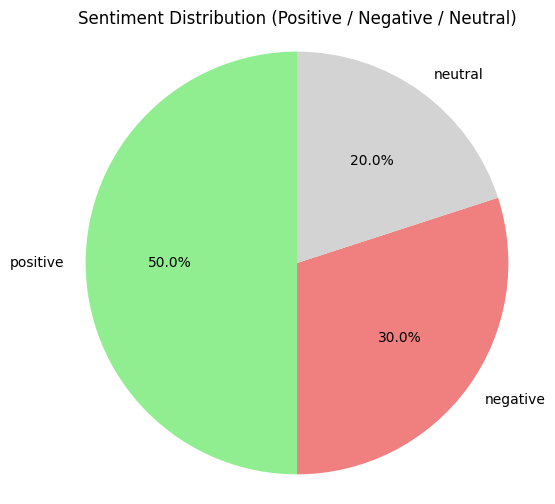

In [53]:
plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightgreen', 'lightcoral', 'lightgrey']  # Positive, Negative, Neutral
)
plt.title("Sentiment Distribution (Positive / Negative / Neutral)")
plt.axis('equal')  # Ensures a perfect circle
plt.show()